In [11]:
# ✅ STEP 1: INSTALL DEPENDENCIES
!pip install gradio opencv-python tensorflow pandas seaborn matplotlib --quiet


In [12]:
# ✅ STEP 2: MOUNT DRIVE & UPLOAD CSV
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
files.upload()  # upload Food_Data.csv here manually


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving Food_Data.csv to Food_Data.csv


{'Food_Data.csv': b'Food Item,Calories(kcal),Carbs (g),Protein (g),Fat (g),Serving Size (g/ml)\r\nAloo Paratha,290,32,7,14,120\r\nPaneer Paratha,330,28,11,17,130\r\nGobi Paratha,270,30,6,13,120\r\nMooli Paratha,260,29,5,12,125\r\nLachha Paratha,300,31,6,15,130\r\nOnion Paratha,280,30,6,13,120\r\nPlain Paratha,260,28,5,12,100\r\nCheese Paratha,350,30,9,20,150\r\nEgg Paratha,320,27,10,17,140\r\nMixed Veg Paratha,310,30,8,15,130\r\nPalak Paratha,240,25,6,10,110\r\nVanilla Ice Cream,137,16,2,7,80\r\nChocolate Ice Cream,143,17,2,7,80\r\nStrawberry Ice Cream,127,15,1.5,6,80\r\nButterscotch Ice Cream,155,18,2,8,80\r\nMango Ice Cream,135,16,2,6,80\r\nKulfi,190,21,4,10,70\r\nPistachio Ice Cream,160,17,3,8,80\r\nChoco Chip Ice Cream,165,19,3,8,80\r\nCoffee Ice Cream,130,15,2,6,80\r\nCoconut Ice Cream,140,16,2,7,80\r\nTutti Frutti Ice Cream,145,17,2,7,80\r\nWhite Rice,206,45,4,0.4,180\r\nJeera Rice,230,47,4,2,180\r\nVeg Fried Rice,250,40,6,8,220\r\nEgg Fried Rice,275,38,8,10,220\r\nChicken Fried 

In [13]:
# ✅ STEP 3: LOAD & CLEAN CSV
import pandas as pd

df_nutrition = pd.read_csv("Food_Data.csv")
df_nutrition['Food Item'] = df_nutrition['Food Item'].str.lower().str.strip().str.replace(" ", "_")
df_nutrition.set_index('Food Item', inplace=True)
df_nutrition.head()


,Calories(kcal),Carbs (g),Protein (g),Fat (g),Serving Size (g/ml)
Food Item,,,,,
aloo_paratha,290,32,7.0,14.0,120
paneer_paratha,330,28,11.0,17.0,130
gobi_paratha,270,30,6.0,13.0,120
mooli_paratha,260,29,5.0,12.0,125
lachha_paratha,300,31,6.0,15.0,130


In [14]:
#LOAD IMAGE DATA
import os, cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 128
image_data, labels = [], []

image_root = "/content/drive/MyDrive/FoodData/FoodData"

for folder in os.listdir(image_root):
    folder_path = os.path.join(image_root, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    img = preprocess_input(img)
                    image_data.append(img)
                    labels.append(folder.lower().strip())

X = np.array(image_data)
le = LabelEncoder()
y = le.fit_transform(labels)


In [15]:
#BUILD MODEL (MobileNetV2)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

y_cat = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(len(np.unique(y)), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 712ms/step - accuracy: 0.0599 - loss: 4.0860 - val_accuracy: 0.1554 - val_loss: 3.4082
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 548ms/step - accuracy: 0.3614 - loss: 2.6141 - val_accuracy: 0.3368 - val_loss: 2.6084
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 529ms/step - accuracy: 0.6376 - loss: 1.5377 - val_accuracy: 0.3627 - val_loss: 2.4366
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 537ms/step - accuracy: 0.8193 - loss: 0.8894 - val_accuracy: 0.4404 - val_loss: 2.1042
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 623ms/step - accuracy: 0.8972 - loss: 0.5536 - val_accuracy: 0.4508 - val_loss: 1.9286
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 727ms/step - accuracy: 0.9329 - loss: 0.4143 - val_accuracy: 0.4663 - val_loss: 1.9262
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 574ms/step - accuracy: 0.9660 - loss: 0.2288 - val_accuracy: 0.4715 - val_loss: 1.8872
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 637ms/

/tmp/ipython-input-16-4007916565.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_foods['Calories(kcal)'], y=top_foods.index, palette='coolwarm')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


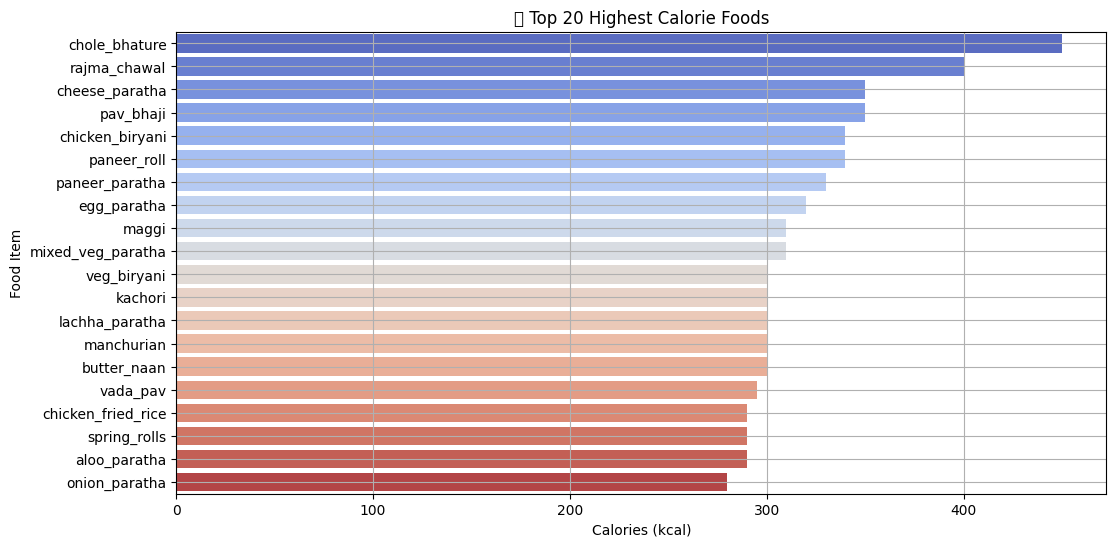

In [16]:
#CALORIE VISUALIZATION
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
top_foods = df_nutrition.sort_values('Calories(kcal)', ascending=False).head(20)
sns.barplot(x=top_foods['Calories(kcal)'], y=top_foods.index, palette='coolwarm')
plt.title("🔥 Top 20 Highest Calorie Foods")
plt.xlabel("Calories (kcal)")
plt.ylabel("Food Item")
plt.grid(True)
plt.show()


In [17]:
#Model Prep
import os, cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 128
image_data, labels = [], []
img_path = "/content/drive/MyDrive/FoodData/FoodData"

for folder in os.listdir(img_path):
    folder_path = os.path.join(img_path, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img = cv2.imread(os.path.join(folder_path, file))
                if img is not None:
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    img = preprocess_input(img)
                    image_data.append(img)
                    labels.append(folder.lower().strip())

X = np.array(image_data)
le = LabelEncoder()
y = le.fit_transform(labels)
y_cat = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(len(np.unique(y)), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 630ms/step - accuracy: 0.0728 - loss: 4.0903 - val_accuracy: 0.2021 - val_loss: 3.4185
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 545ms/step - accuracy: 0.4013 - loss: 2.6328 - val_accuracy: 0.2694 - val_loss: 2.7567
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 602ms/step - accuracy: 0.5994 - loss: 1.6461 - val_accuracy: 0.4041 - val_loss: 2.3343
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.8073 - loss: 0.9511 - val_accuracy: 0.4611 - val_loss: 2.1002
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 670ms/step - accuracy: 0.9340 - loss: 0.5009 - val_accuracy: 0.4922 - val_loss: 1.9271
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 541ms/step - accuracy: 0.9767 - loss: 0.3026 - val_accuracy: 0.5026 - val_loss: 1.8671
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 543ms/step - accuracy: 0.9843 - loss: 0.1904 - val_accuracy: 0.5078 - val_loss: 1.8709
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 574ms/step - accuracy: 0.9804 - loss: 0.1795 - val_accu

In [19]:
df = pd.read_csv("Food_Data.csv")
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
df['food_item'] = df['food_item'].str.lower().str.strip().str.replace(" ", "_")
df.set_index('food_item', inplace=True)


/tmp/ipython-input-20-22162529.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='calories(kcal)', y=top_cal.index, data=top_cal, palette='Reds_r')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


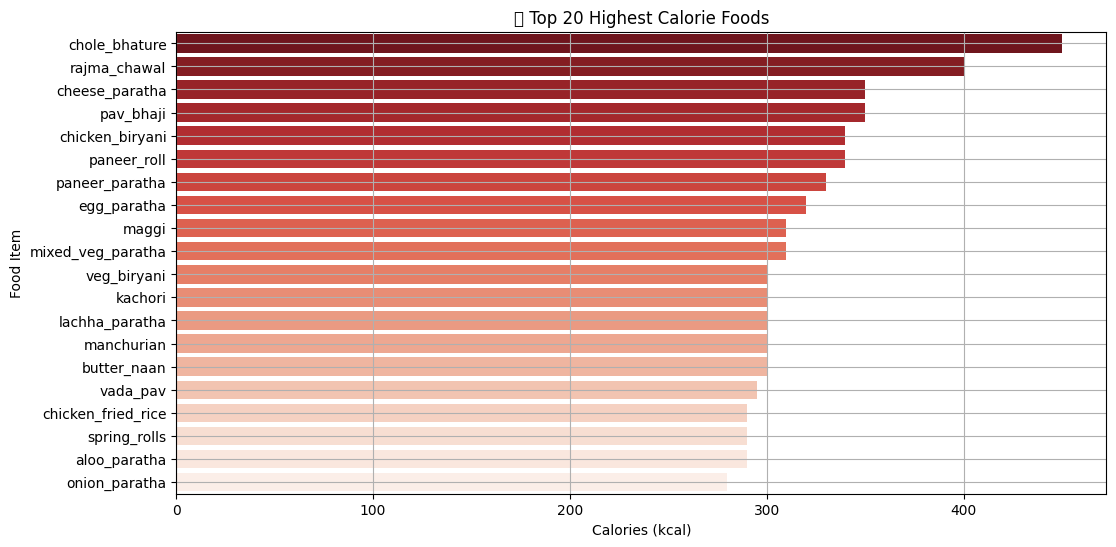

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


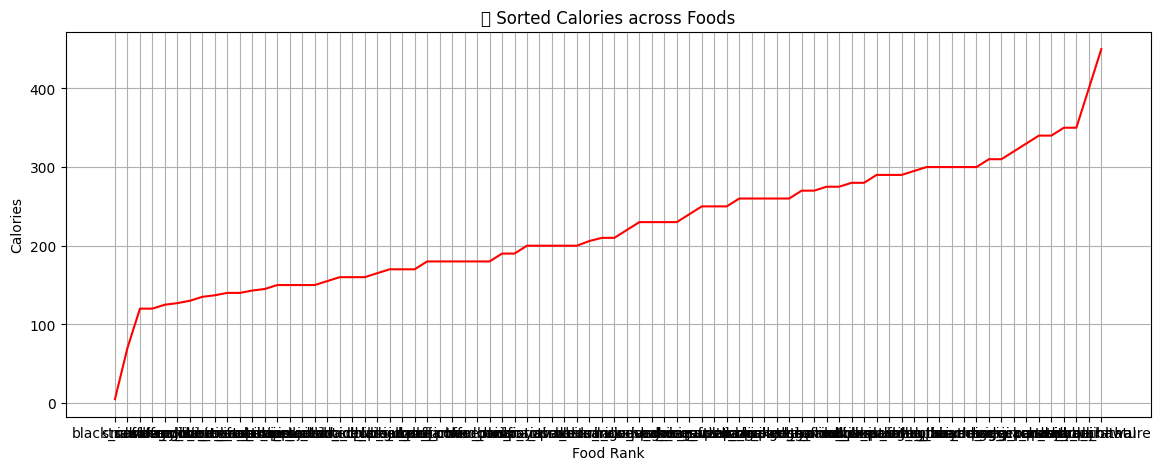

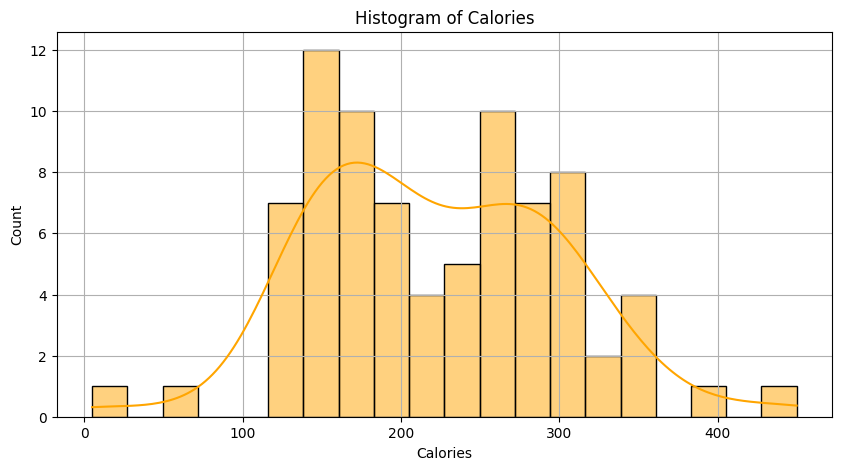

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


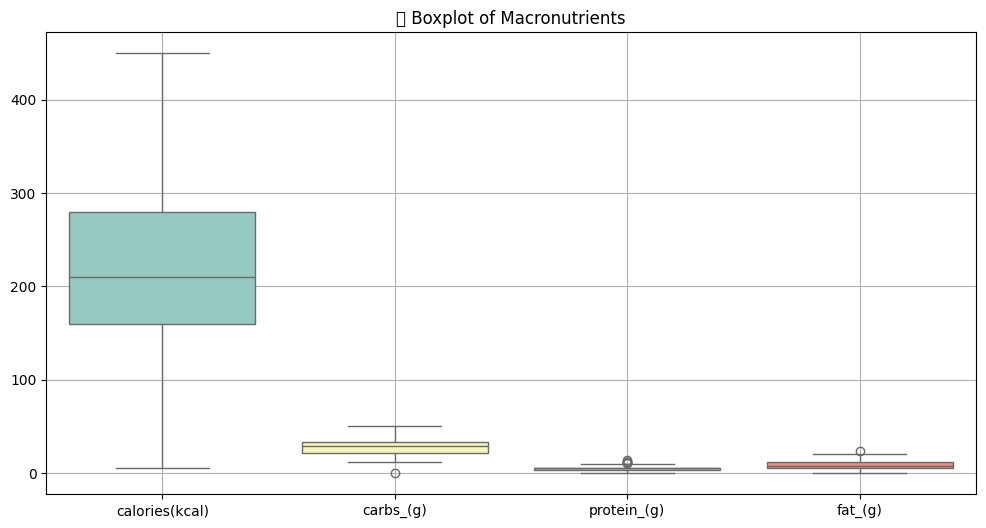

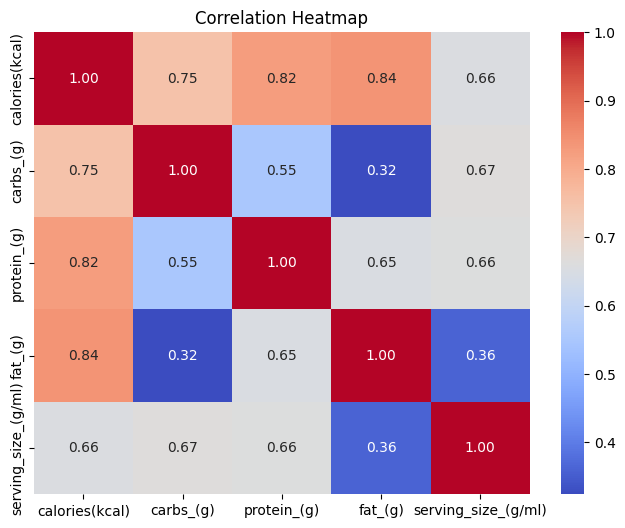

/tmp/ipython-input-20-22162529.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='variable', y='value', data=melted, palette="muted")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


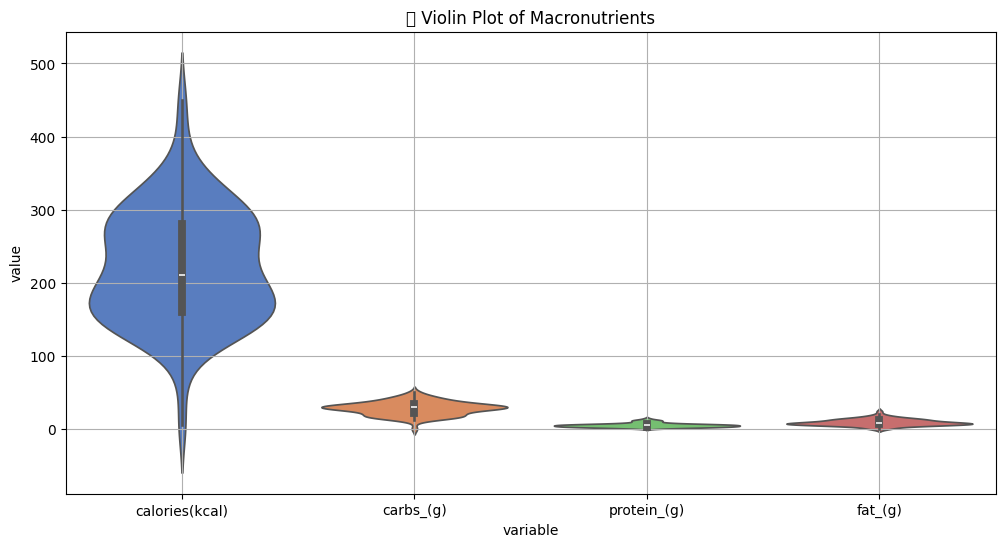

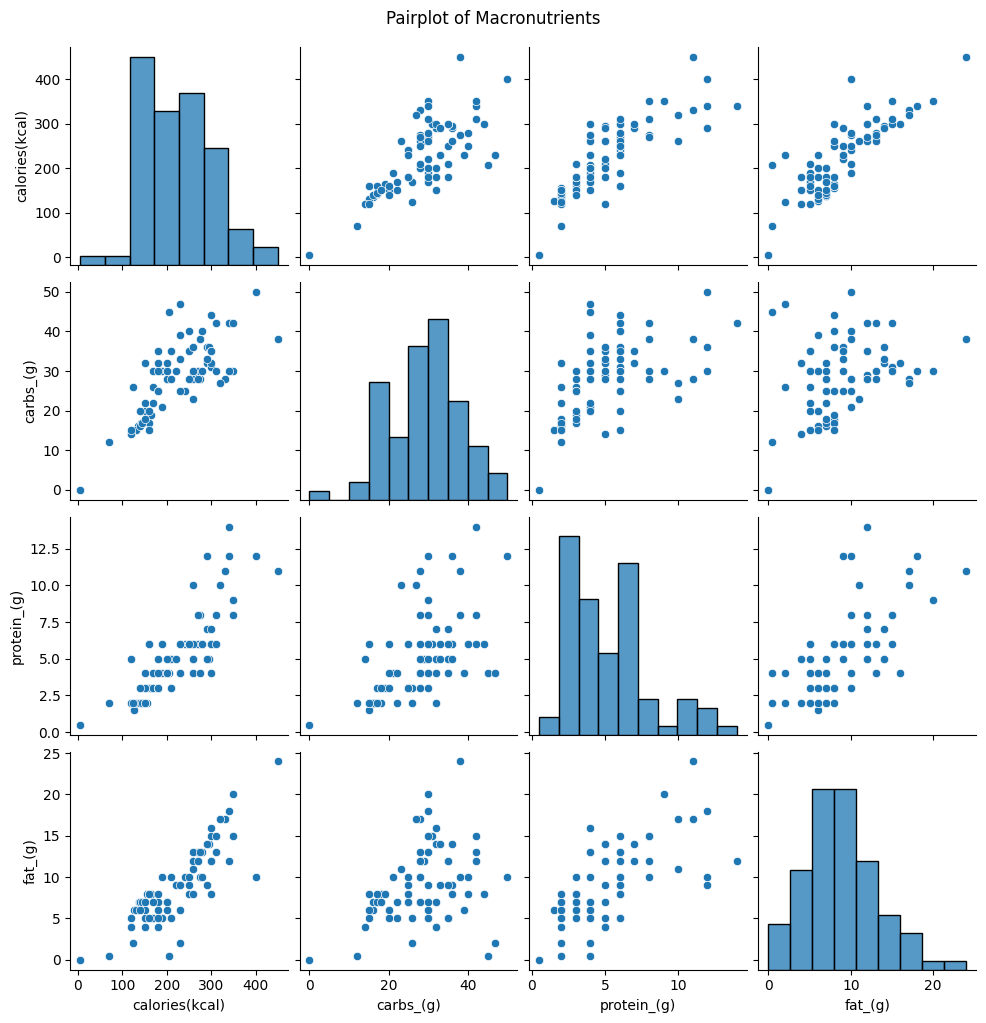

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127869 (\N{FORK AND KNIFE WITH PLATE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


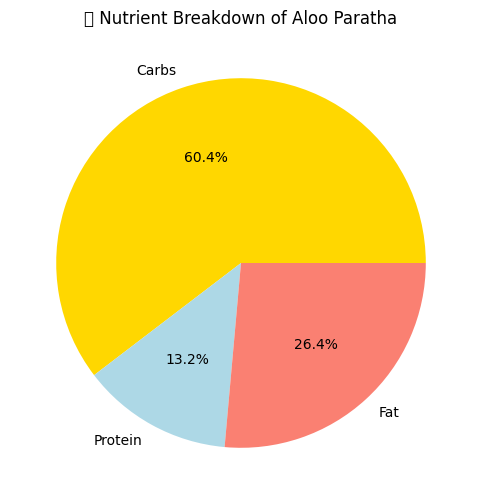

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


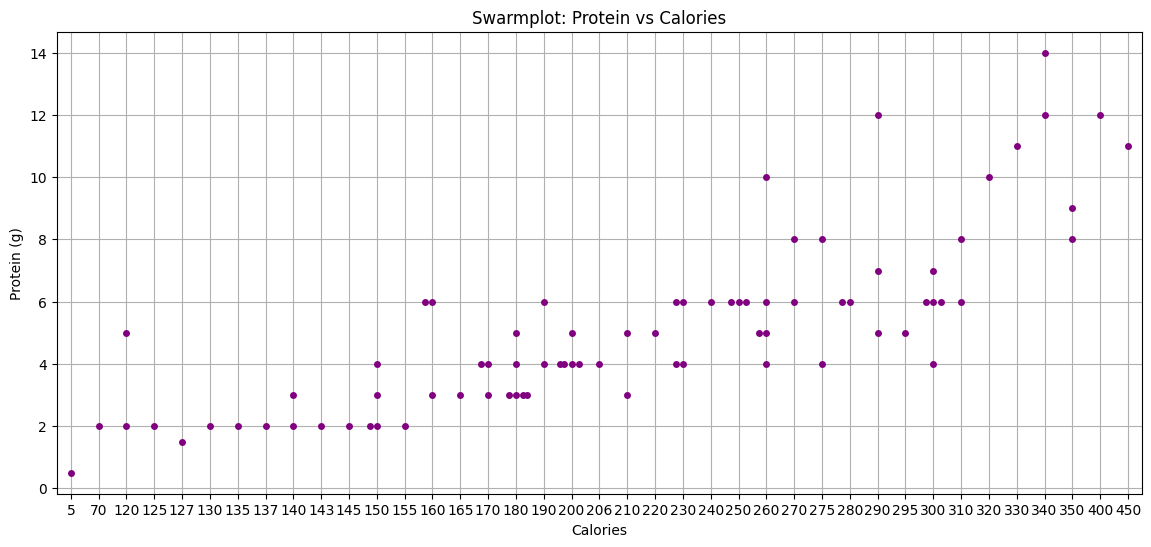

/tmp/ipython-input-20-22162529.py:97: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


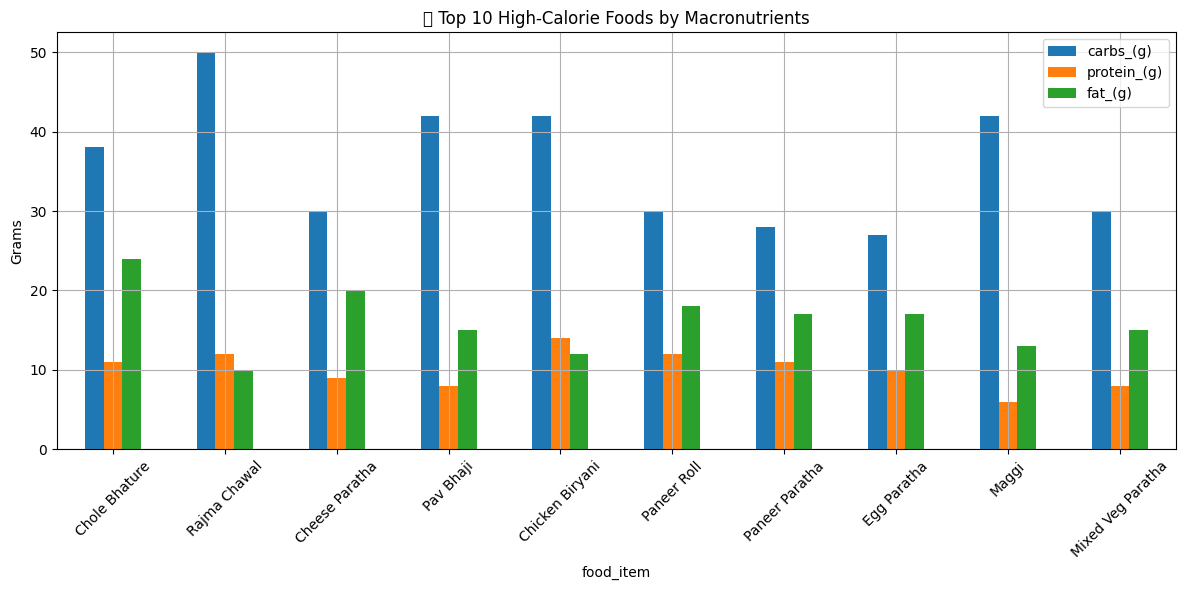

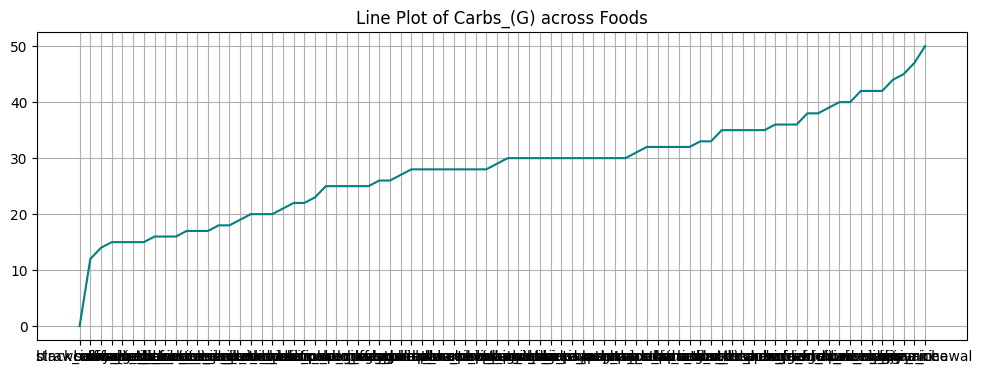

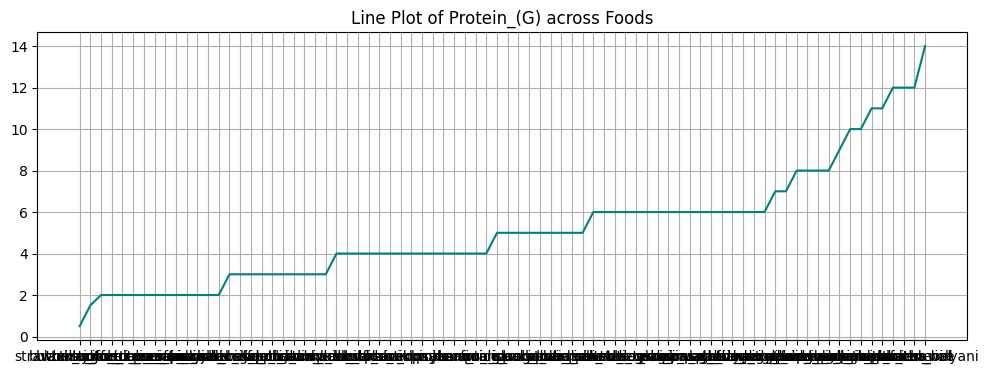

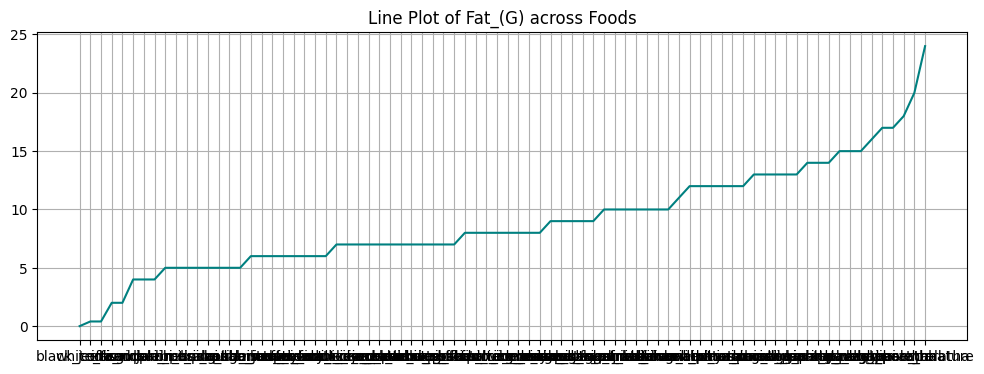

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


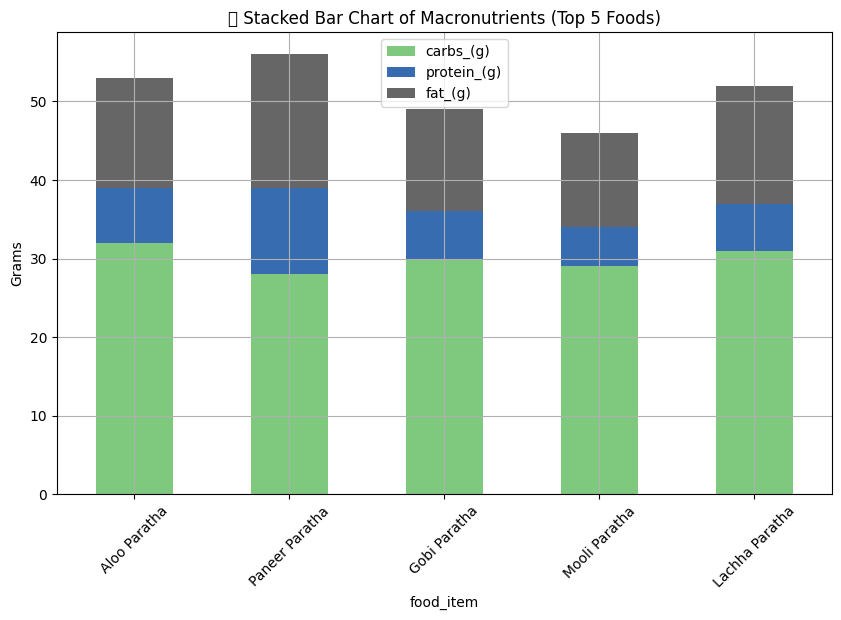

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


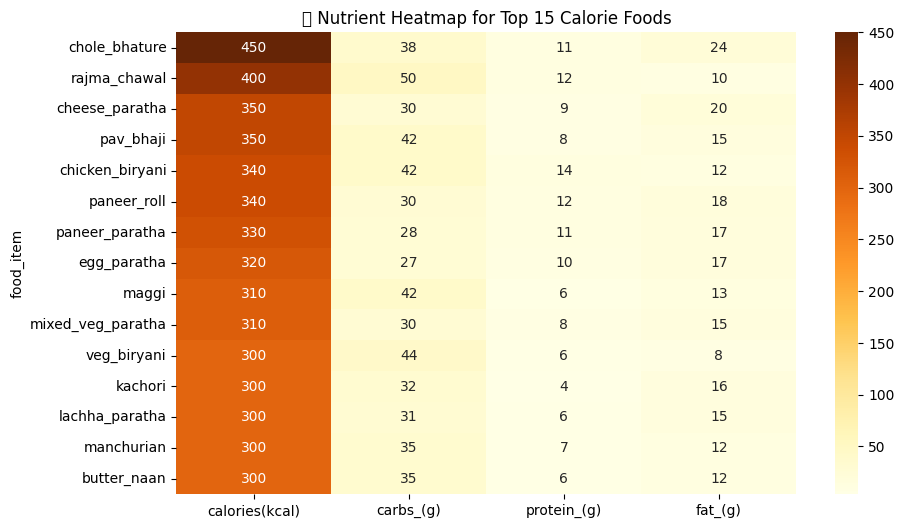

In [20]:
#Bar Chart – Top Calorie Foods
import seaborn as sns
import matplotlib.pyplot as plt

top_cal = df.sort_values('calories(kcal)', ascending=False).head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x='calories(kcal)', y=top_cal.index, data=top_cal, palette='Reds_r')
plt.title("🔥 Top 20 Highest Calorie Foods")
plt.xlabel("Calories (kcal)")
plt.ylabel("Food Item")
plt.grid(True)
plt.show()


#Line Chart – Calories Sorted
sorted_cal = df.sort_values('calories(kcal)', ascending=True)
plt.figure(figsize=(14, 5))
plt.plot(sorted_cal['calories(kcal)'], label='Calories', color='red')
plt.title("📈 Sorted Calories across Foods")
plt.ylabel("Calories")
plt.xlabel("Food Rank")
plt.grid(True)
plt.show()


#Histogram – Calories Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['calories(kcal)'], bins=20, kde=True, color='orange')
plt.title("Histogram of Calories")
plt.xlabel("Calories")
plt.ylabel("Count")
plt.grid(True)
plt.show()


#Boxplot – Macronutrient Distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['calories(kcal)', 'carbs_(g)', 'protein_(g)', 'fat_(g)']], palette="Set3")
plt.title("📦 Boxplot of Macronutrients")
plt.grid(True)
plt.show()


#Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#Violin Plot – Nutrient Spread
df_reset = df.reset_index()
melted = df_reset.melt(id_vars='food_item', value_vars=['calories(kcal)', 'carbs_(g)', 'protein_(g)', 'fat_(g)'])

plt.figure(figsize=(12, 6))
sns.violinplot(x='variable', y='value', data=melted, palette="muted")
plt.title("🎻 Violin Plot of Macronutrients")
plt.grid(True)
plt.show()



#Pairplot – Feature Comparison
sns.pairplot(df_reset[['calories(kcal)', 'carbs_(g)', 'protein_(g)', 'fat_(g)']])
plt.suptitle("Pairplot of Macronutrients", y=1.02)
plt.show()


#Pie Chart – Nutrient Breakdown of One Food
food = "aloo_paratha"
row = df.loc[food]
plt.figure(figsize=(6, 6))
plt.pie([row['carbs_(g)'], row['protein_(g)'], row['fat_(g)']],
        labels=['Carbs', 'Protein', 'Fat'], autopct='%1.1f%%',
        colors=['gold', 'lightblue', 'salmon'])
plt.title(f"🍽️ Nutrient Breakdown of {food.replace('_', ' ').title()}")
plt.show()


#Swarmplot – Protein vs Calories
plt.figure(figsize=(14, 6))
sns.swarmplot(x='calories(kcal)', y='protein_(g)', data=df_reset, color='purple', size=5)
plt.title("Swarmplot: Protein vs Calories")
plt.xlabel("Calories")
plt.ylabel("Protein (g)")
plt.grid(True)
plt.show()


#Clustered Bar Chart – Top 10 Foods
top10 = df.sort_values('calories(kcal)', ascending=False).head(10)
top10[['carbs_(g)', 'protein_(g)', 'fat_(g)']].plot(kind='bar', figsize=(12, 6))
plt.title("📊 Top 10 High-Calorie Foods by Macronutrients")
plt.ylabel("Grams")
plt.xticks(ticks=range(10), labels=[i.replace("_", " ").title() for i in top10.index], rotation=45)
plt.grid(True)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()



#Line Plots for Each Macronutrient
for nutrient in ['carbs_(g)', 'protein_(g)', 'fat_(g)']:
    sorted_df = df.sort_values(nutrient, ascending=True)
    plt.figure(figsize=(12, 4))
    plt.plot(sorted_df[nutrient], label=nutrient.title(), color='teal')
    plt.title(f"Line Plot of {nutrient.title()} across Foods")
    plt.grid(True)
    plt.show()


#Stacked Bar Plot – Nutrient Composition
top5 = df.head(5)[['carbs_(g)', 'protein_(g)', 'fat_(g)']]
top5.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Accent')
plt.title("📊 Stacked Bar Chart of Macronutrients (Top 5 Foods)")
plt.ylabel("Grams")
plt.xticks(ticks=range(5), labels=[i.replace("_", " ").title() for i in top5.index], rotation=45)
plt.grid(True)
plt.show()


#Heatmap of Top 15 Foods
top15 = df.sort_values('calories(kcal)', ascending=False).head(15)
plt.figure(figsize=(10, 6))
sns.heatmap(top15[['calories(kcal)', 'carbs_(g)', 'protein_(g)', 'fat_(g)']], annot=True, fmt=".0f", cmap='YlOrBr')
plt.title("🔥 Nutrient Heatmap for Top 15 Calorie Foods")
plt.show()






In [21]:
#Install + Upload CSV
!pip install gradio pandas matplotlib seaborn --quiet
import pandas as pd
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
files.upload()  # Upload Food_Data.csv


Saving Food_Data.csv to Food_Data (1).csv


{'Food_Data (1).csv': b'Food Item,Calories(kcal),Carbs (g),Protein (g),Fat (g),Serving Size (g/ml)\r\nAloo Paratha,290,32,7,14,120\r\nPaneer Paratha,330,28,11,17,130\r\nGobi Paratha,270,30,6,13,120\r\nMooli Paratha,260,29,5,12,125\r\nLachha Paratha,300,31,6,15,130\r\nOnion Paratha,280,30,6,13,120\r\nPlain Paratha,260,28,5,12,100\r\nCheese Paratha,350,30,9,20,150\r\nEgg Paratha,320,27,10,17,140\r\nMixed Veg Paratha,310,30,8,15,130\r\nPalak Paratha,240,25,6,10,110\r\nVanilla Ice Cream,137,16,2,7,80\r\nChocolate Ice Cream,143,17,2,7,80\r\nStrawberry Ice Cream,127,15,1.5,6,80\r\nButterscotch Ice Cream,155,18,2,8,80\r\nMango Ice Cream,135,16,2,6,80\r\nKulfi,190,21,4,10,70\r\nPistachio Ice Cream,160,17,3,8,80\r\nChoco Chip Ice Cream,165,19,3,8,80\r\nCoffee Ice Cream,130,15,2,6,80\r\nCoconut Ice Cream,140,16,2,7,80\r\nTutti Frutti Ice Cream,145,17,2,7,80\r\nWhite Rice,206,45,4,0.4,180\r\nJeera Rice,230,47,4,2,180\r\nVeg Fried Rice,250,40,6,8,220\r\nEgg Fried Rice,275,38,8,10,220\r\nChicken Fr

In [22]:
#Load + Clean CSV
df = pd.read_csv("Food_Data.csv")

# Clean column names
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
df['food_item'] = df['food_item'].str.lower().str.strip().str.replace(" ", "_")
df.set_index('food_item', inplace=True)
df = df.dropna()


In [24]:
!pip install gradio pandas matplotlib seaborn --quiet
import pandas as pd
import gradio as gr
import matplotlib.pyplot as plt

# Load and clean CSV
df = pd.read_csv("Food_Data.csv")
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
df['food_item'] = df['food_item'].str.lower().str.strip().str.replace(" ", "_")
df.set_index('food_item', inplace=True)
df = df.dropna()

# Function for food info and pie chart
def show_nutrient_info(food_name):
    if food_name not in df.index:
        return f"❌ {food_name} not found!", None

    row = df.loc[food_name]
    info = f"""
### 📌 {food_name.replace('_', ' ').title()}

🔥 **Calories**: {row['calories(kcal)']} kcal
🍞 **Carbs**: {row['carbs_(g)']} g
🍗 **Protein**: {row['protein_(g)']} g
🧈 **Fat**: {row['fat_(g)']} g
📏 **Serving Size**: {row['serving_size_(g/ml)']} g/ml
"""

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.pie([row['carbs_(g)'], row['protein_(g)'], row['fat_(g)']],
           labels=['Carbs', 'Protein', 'Fat'],
           autopct='%1.1f%%',
           colors=['#f4e1c1', '#cdb599', '#a1887f'])
    ax.set_title("🥧 Macronutrient Composition")
    return info, fig

# Dropdown options
food_list = sorted(df.index.tolist())

# 🌟 Custom CSS style (light beige)
custom_css = """
body { background-color: #fdf6ee !important; }
h1, h2, h3, h4, h5, h6 { font-family: 'Segoe UI', sans-serif !important; color: #5c4033 !important; }
footer { text-align: center; color: #5c4033; font-size: 14px; margin-top: 40px; }
"""

# Launch Gradio Interface
gr.Interface(
    fn=show_nutrient_info,
    inputs=gr.Dropdown(choices=food_list, label="🔽 Select Food Item"),
    outputs=["markdown", "plot"],
    title="🍽️ FOOD CALORIE ESTIMATION USING CNN",
    description="An aesthetic dashboard to explore food calories and macronutrients.",
    article="<footer><b>PRESENTED BY TEAM ASAP</b></footer>",
    css=custom_css
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bfa88b4e42f7e3b3f5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/tmp/ipython-input-25-715801316.py:28: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129383 (\N{PIE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


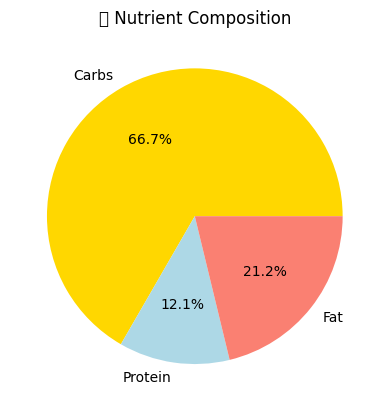

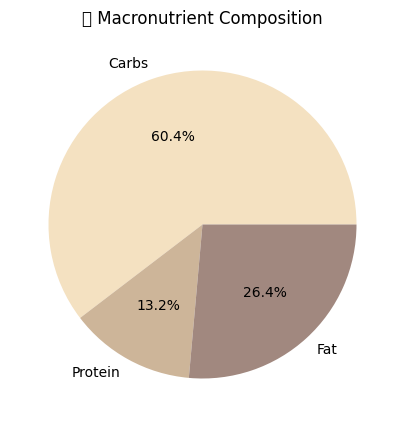

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


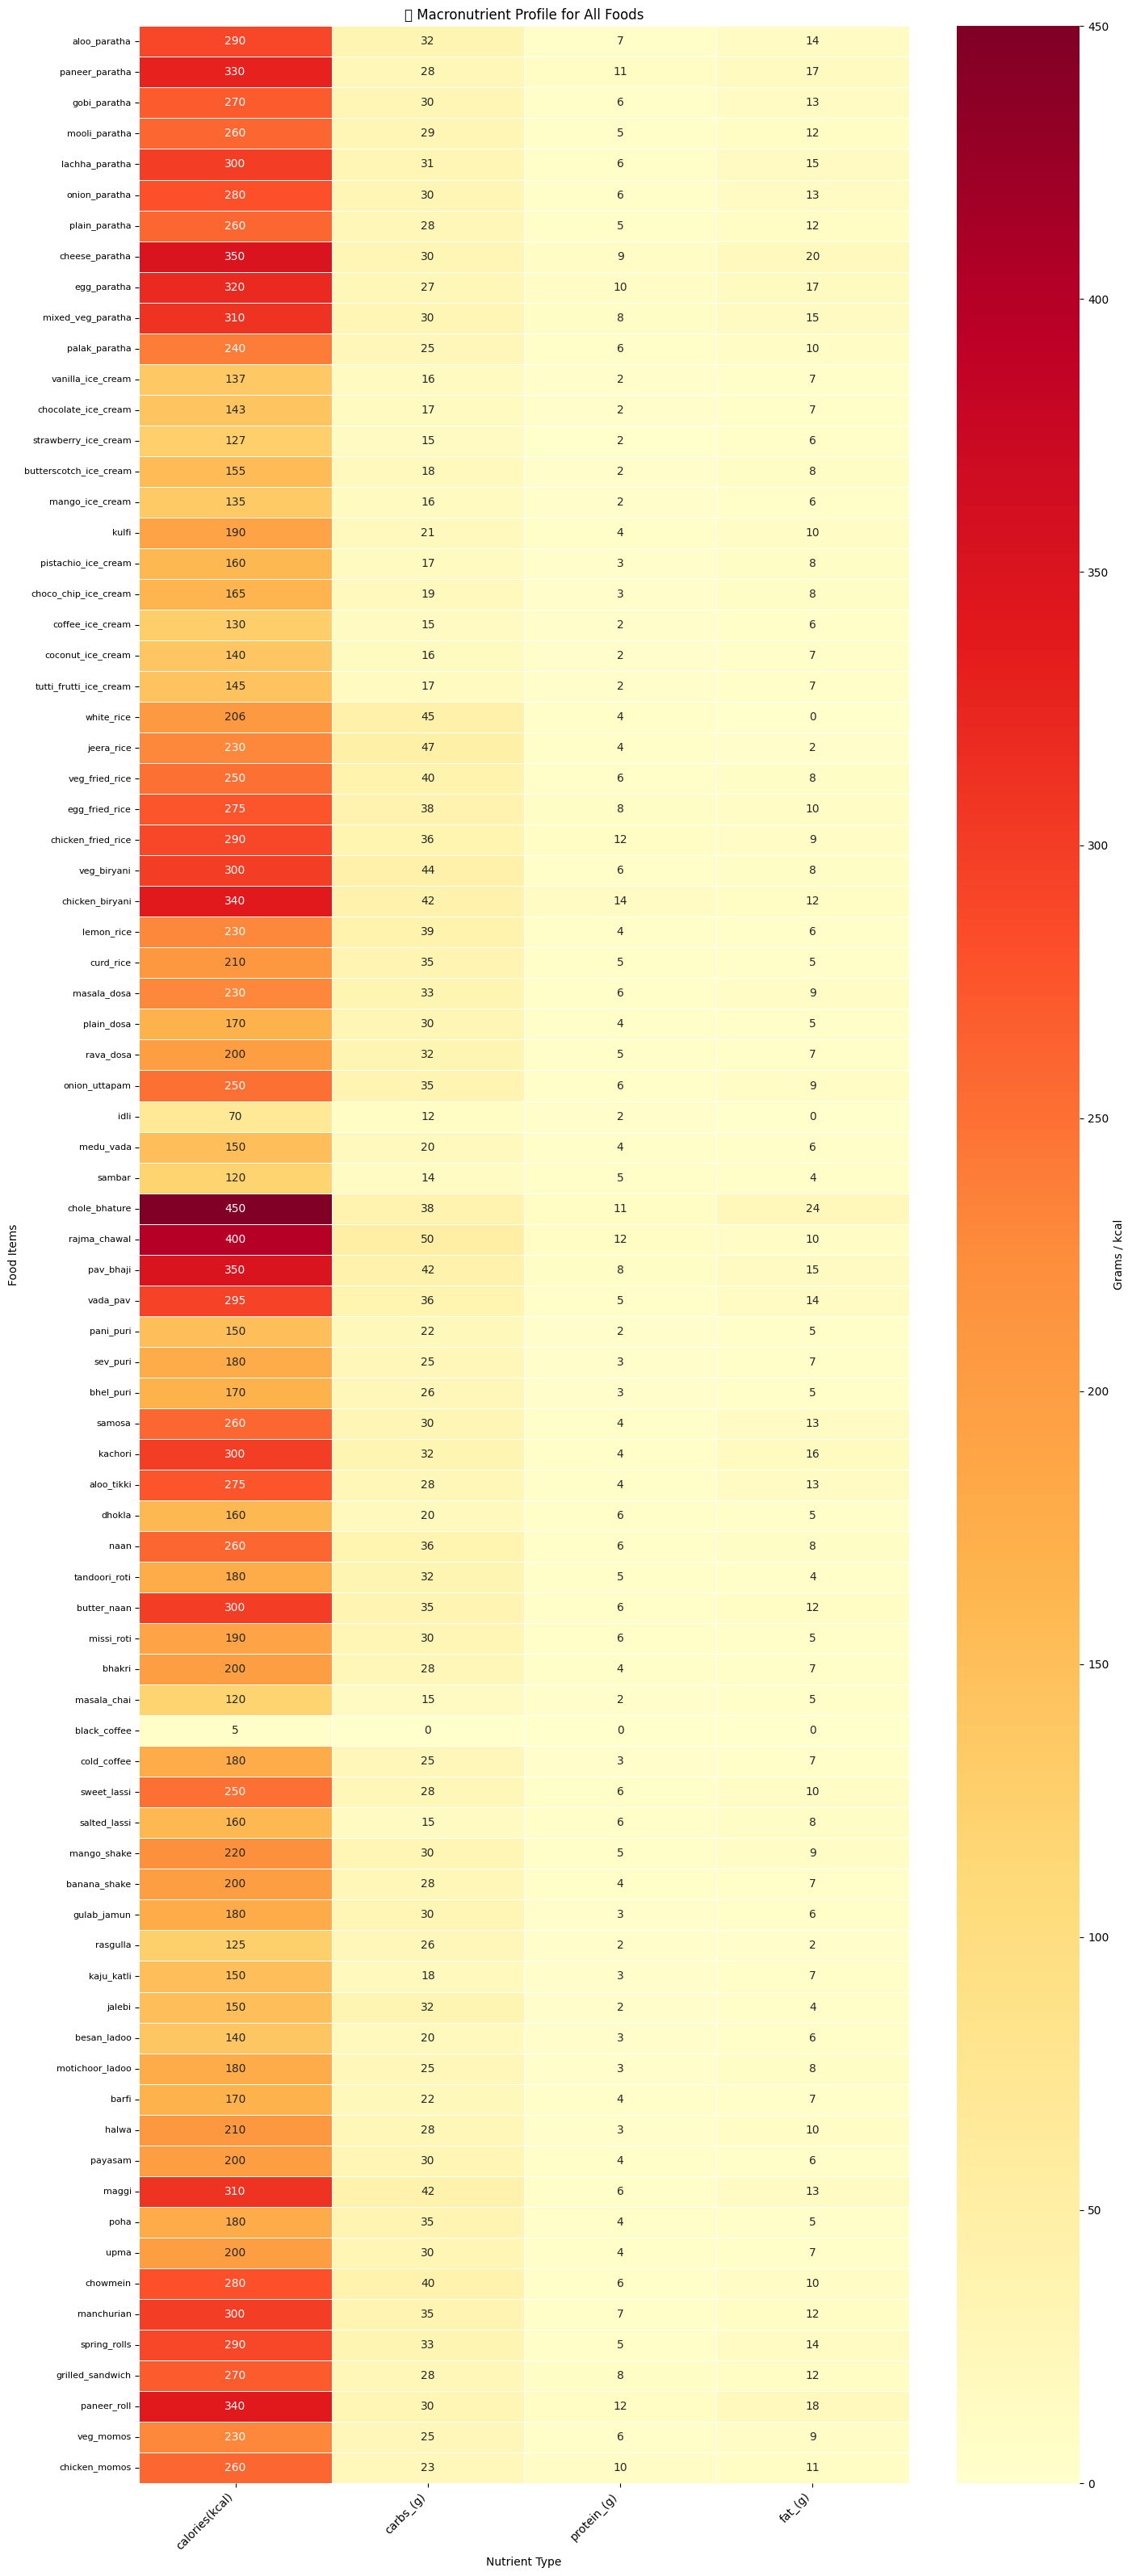

In [25]:
#Full Heatmap With Proper Labels for All Foods
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and clean the data
df = pd.read_csv("Food_Data.csv")
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
df['food_item'] = df['food_item'].str.lower().str.strip().str.replace(" ", "_")
df.set_index('food_item', inplace=True)
df = df.dropna()

# Select only relevant nutrient columns
nutrient_df = df[['calories(kcal)', 'carbs_(g)', 'protein_(g)', 'fat_(g)']]

# Plot heatmap
plt.figure(figsize=(14, len(nutrient_df) * 0.4))  # Dynamically set height
sns.heatmap(nutrient_df, cmap="YlOrRd", annot=True, fmt=".0f", linewidths=0.5,
            cbar_kws={'label': 'Grams / kcal'})
plt.title("🔥 Macronutrient Profile for All Foods")
plt.xlabel("Nutrient Type")
plt.ylabel("Food Items")

# Improve Y-axis labels
plt.yticks(rotation=0, fontsize=8)  # Keep food names readable
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [26]:
import pandas as pd
import gradio as gr
import seaborn as sns
import matplotlib.pyplot as plt

# 📥 Load and clean CSV
df = pd.read_csv("Food_Data.csv")
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
df['food_item'] = df['food_item'].str.lower().str.strip().str.replace(" ", "_")
df.set_index('food_item', inplace=True)
df = df.dropna()

# ✅ Define function for visualization output
def show_macronutrient_info(food_name):
    if food_name not in df.index:
        return "❌ Food not found.", None, None

    # PIE CHART – Macronutrients for selected food
    row = df.loc[food_name]
    pie_fig, ax = plt.subplots(figsize=(5, 5))
    ax.pie([row['carbs_(g)'], row['protein_(g)'], row['fat_(g)']],
           labels=['Carbs', 'Protein', 'Fat'],
           autopct='%1.1f%%',
           colors=['#F5CBA7', '#A3E4D7', '#F1948A'])
    ax.set_title(f"🥧 Macronutrient Breakdown of {food_name.replace('_', ' ').title()}")

    # HEATMAP – All foods' nutrients
    nutrient_df = df[['calories(kcal)', 'carbs_(g)', 'protein_(g)', 'fat_(g)']]
    heatmap_fig, ax2 = plt.subplots(figsize=(12, min(30, len(nutrient_df) * 0.35)))
    sns.heatmap(nutrient_df, cmap="YlOrRd", annot=False, linewidths=0.3, ax=ax2)
    ax2.set_title("🔥 Macronutrient Heatmap of All Foods")
    ax2.set_xlabel("Nutrients")
    ax2.set_ylabel("Food Items")
    ax2.set_yticklabels([label.get_text().replace('_', ' ').title() for label in ax2.get_yticklabels()], fontsize=7)

    return f"""### 📌 {food_name.replace('_', ' ').title()}
🔥 **Calories**: {row['calories(kcal)']} kcal
🍞 **Carbs**: {row['carbs_(g)']} g
🍗 **Protein**: {row['protein_(g)']} g
🧈 **Fat**: {row['fat_(g)']} g
📏 **Serving Size**: {row['serving_size_(g/ml)']} g/ml""", pie_fig, heatmap_fig


In [27]:
# 📋 Dropdown values
food_list = sorted(df.index.tolist())

# 🎨 Custom CSS theme (beige-white-light brown)
custom_css = """
body {
    background-color: #fdf6ee !important;
}
h1, h2, h3, h4, h5, h6 {
    color: #5c4033 !important;
    font-family: 'Segoe UI', sans-serif !important;
}
footer {
    text-align: center;
    color: #5c4033;
    font-size: 14px;
    margin-top: 40px;
}
"""

# 🎛️ Gradio App
gr.Interface(
    fn=show_macronutrient_info,
    inputs=gr.Dropdown(choices=food_list, label="🔽 Select Food Item"),
    outputs=["markdown", "plot", "plot"],
    title="🍽️ FOOD CALORIE ESTIMATION USING CNN",
    description="Interactively explore food nutrients with aesthetic visualizations.",
    article="<footer><b>PRESENTED BY TEAM ASAP</b></footer>",
    css=custom_css
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b167b1a6d366f7174f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [29]:
from PIL import Image
import requests
from io import BytesIO

def fetch_food_image(query):
    try:
        # Fetch from Google (Unsplash-style endpoint)
        url = f"https://source.unsplash.com/400x300/?{query},food"
        response = requests.get(url)
        return Image.open(BytesIO(response.content))
    except:
        return None


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_macronutrient_info(selected_food):
    if selected_food not in df.index:
        return "Food not found.", None, None

    row = df.loc[selected_food]

    # 📄 Macronutrient Info
    markdown = (f"### 🍽️ {selected_food.replace('_',' ').title()}\n"
                f"**Calories**: {row['calories(kcal)']} kcal\n\n"
                f"**Carbs**: {row['carbs_(g)']} g\n"
                f"**Protein**: {row['protein_(g)']} g\n"
                f"**Fat**: {row['fat_(g)']} g\n"
                f"**Serving**: {row['serving_size_(g/ml)']} g/ml")

    # 🥧 Macronutrient Pie
    fig1, ax1 = plt.subplots(figsize=(4, 4))
    ax1.pie([row['carbs_(g)'], row['protein_(g)'], row['fat_(g)']],
            labels=['Carbs', 'Protein', 'Fat'], autopct='%1.1f%%',
            colors=['#f4e1c1', '#cdb599', '#a1887f'])
    ax1.set_title("Macronutrient Distribution")

    # 🔥 Correlation Heatmap
    fig2, ax2 = plt.subplots(figsize=(5, 4))
    sns.heatmap(df[['carbs_(g)', 'protein_(g)', 'fat_(g)', 'calories(kcal)']].corr(),
                annot=True, cmap='YlOrBr', fmt=".2f", ax=ax2)
    ax2.set_title("Nutrient Correlation")

    return markdown, fig1, fig2


In [31]:
import gradio as gr

def get_image_from_text(food_name):
    food_img = fetch_food_image(food_name.replace("_", " "))
    return food_img
#Define Food Image Gradio Component (Separate)

In [32]:
#Define Gradio Dashboard with CSS and All Outputs
# 📋 Dropdown values
food_list = sorted(df.index.tolist())

# 🎨 Custom CSS theme
custom_css = """
body {
    background-color: #fdf6ee !important;
}
h1, h2, h3, h4, h5, h6 {
    color: #5c4033 !important;
    font-family: 'Segoe UI', sans-serif !important;
}
footer {
    text-align: center;
    color: #5c4033;
    font-size: 14px;
    margin-top: 40px;
}
"""

with gr.Blocks(css=custom_css) as demo:
    gr.Markdown("## 🍲 FOOD CALORIE ESTIMATION DASHBOARD")
    gr.Markdown("Upload food image or select from dropdown to view nutrients & chart.")

    with gr.Row():
        food_dropdown = gr.Dropdown(choices=food_list, label="🔽 Select Food Item")

    with gr.Row():
        out1 = gr.Markdown()
        out2 = gr.Plot()
        out3 = gr.Plot()
        out4 = gr.Image(type="pil", label="Representative Food Image")

    def full_pipeline(food):
        info_md, pie_fig, heatmap_fig = show_macronutrient_info(food)
        food_img = get_image_from_text(food)
        return info_md, pie_fig, heatmap_fig, food_img

    food_dropdown.change(full_pipeline, inputs=[food_dropdown],
                         outputs=[out1, out2, out3, out4])

    gr.Markdown("<footer><b>PRESENTED BY TEAM ASAP</b></footer>")

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a292773db2db998463.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [35]:
#Define Image Fallback Fetcher

from PIL import Image
import requests
from io import BytesIO

def get_image_from_text(query):
    try:
        url = f"https://source.unsplash.com/400x300/?{query.replace('_','%20')},food"
        response = requests.get(url, timeout=5)
        return Image.open(BytesIO(response.content))
    except:
        return None


In [36]:
#Macronutrient Plot & Heatmap Generator
import matplotlib.pyplot as plt
import seaborn as sns

def show_macronutrient_info(sel_food):
    if sel_food not in df.index:
        return "❌ Food not found", None, None

    row = df.loc[sel_food]

    markdown = (
        f"### 🍽️ {sel_food.replace('_',' ').title()}\n"
        f"🔥 **Calories**: {row['calories(kcal)']} kcal\n"
        f"🍞 **Carbs**: {row['carbs_(g)']} g\n"
        f"🍗 **Protein**: {row['protein_(g)']} g\n"
        f"🧈 **Fat**: {row['fat_(g)']} g\n"
        f"📏 **Serving Size**: {row['serving_size_(g/ml)']} g/ml"
    )

    fig_pie, ax_pie = plt.subplots()
    ax_pie.pie([row['carbs_(g)'], row['protein_(g)'], row['fat_(g)']],
               labels=['Carbs', 'Protein', 'Fat'], autopct='%1.1f%%',
               colors=['#f4e1c1', '#cdb599', '#a1887f'])
    ax_pie.set_title("Macronutrient Breakdown")
    plt.tight_layout()

    fig_heat, ax_heat = plt.subplots()
    sns.heatmap(df[['calories(kcal)', 'carbs_(g)', 'protein_(g)', 'fat_(g)']].corr(),
                annot=True, cmap="OrRd", ax=ax_heat)
    ax_heat.set_title("Macronutrient Correlation Heatmap")
    plt.tight_layout()

    return markdown, fig_pie, fig_heat


In [37]:
# Launch Aesthetic Gradio Dashboard
import gradio as gr

food_list = sorted(df.index.tolist())

custom_css = """
body {
    background-color: #fdf6ee !important;
}
h1, h2, h3, h4, h5, h6 {
    color: #5c4033 !important;
    font-family: 'Segoe UI', sans-serif !important;
}
footer {
    text-align: center;
    color: #5c4033;
    font-size: 14px;
    margin-top: 40px;
}
"""

with gr.Blocks(css=custom_css) as demo:
    gr.Markdown("## 🍲 FOOD CALORIE ESTIMATION DASHBOARD")
    gr.Markdown("Upload food image or select from dropdown to view nutrients & chart.")

    with gr.Row():
        food_dropdown = gr.Dropdown(choices=food_list, label="🔽 Select Food Item")

    with gr.Row():
        out1 = gr.Markdown()
        out2 = gr.Plot()
        out3 = gr.Plot()
        out4 = gr.Image(type="pil", label="Representative Food Image")

    def full_pipeline(food):
        info_md, pie_fig, heatmap_fig = show_macronutrient_info(food)
        food_img = get_image_from_text(food)
        return info_md, pie_fig, heatmap_fig, food_img

    food_dropdown.change(full_pipeline, inputs=[food_dropdown],
                         outputs=[out1, out2, out3, out4])

    gr.Markdown("<footer><b>PRESENTED BY TEAM ASAP</b></footer>")

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2d5f7b3a8b467de0b8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [38]:
# Launch Aesthetic Gradio Dashboard (without image)
import gradio as gr

food_list = sorted(df.index.tolist())

custom_css = """
body {
    background-color: #fdf6ee !important;
}
h1, h2, h3, h4, h5, h6 {
    color: #5c4033 !important;
    font-family: 'Segoe UI', sans-serif !important;
}
footer {
    text-align: center;
    color: #5c4033;
    font-size: 14px;
    margin-top: 40px;
}
"""

with gr.Blocks(css=custom_css) as demo:
    gr.Markdown("## 🍲 FOOD CALORIE ESTIMATION DASHBOARD")
    gr.Markdown("Upload food image or select from dropdown to view nutrients & chart.")

    with gr.Row():
        food_dropdown = gr.Dropdown(choices=food_list, label="🔽 Select Food Item")

    with gr.Row():
        out1 = gr.Markdown()
        out2 = gr.Plot()
        out3 = gr.Plot()

    def full_pipeline(food):
        info_md, pie_fig, heatmap_fig = show_macronutrient_info(food)
        return info_md, pie_fig, heatmap_fig

    food_dropdown.change(full_pipeline, inputs=[food_dropdown],
                         outputs=[out1, out2, out3])

    gr.Markdown("<footer><b>PRESENTED BY TEAM ASAP</b></footer>")

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6af96e46cc1cce47cf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [47]:
# Launch Aesthetic Gradio Dashboard (without image)
import gradio as gr

food_list = sorted(df.index.tolist())

# ----------- Macronutrient Visualization Functions -----------------
def show_macronutrient_info(food):
    row = df.loc[food]

    markdown = (
        f"### 🍛 {food.replace('_', ' ').title()}\n"
        f"**Calories**: {row['calories(kcal)']} kcal\n\n"
        f"**Carbs**: {row['carbs_(g)']}g\n"
        f"**Protein**: {row['protein_(g)']}g\n"
        f"**Fat**: {row['fat_(g)']}g\n"
        f"**Serving Size**: {row['serving_size_(g/ml)']}g/ml"
    )

    # Pie chart
    pie_fig, ax1 = plt.subplots(figsize=(4, 4))
    ax1.pie(
        [row['carbs_(g)'], row['protein_(g)'], row['fat_(g)']],
        labels=["Carbs", "Protein", "Fat"],
        autopct='%1.1f%%',
        colors=["#f4e1c1", "#cdb599", "#a1887f"]
    )
    ax1.set_title("Macronutrient Ratio")

    # Heatmap
    heatmap_fig, ax2 = plt.subplots(figsize=(5, 4))
    sns.heatmap(df[['carbs_(g)', 'protein_(g)', 'fat_(g)', 'calories(kcal)']].corr(),
                annot=True, cmap='Oranges', fmt=".2f", ax=ax2)
    ax2.set_title("Macronutrient Correlation Heatmap")

    return markdown, pie_fig, heatmap_fig

# ----------- Standard Nutrition Chatbot -----------------
faq_data = {
    "🍱 What is a balanced diet?": "A balanced diet includes carbs, proteins, fats, vitamins, and minerals in proper proportions.",
    "💪 How much protein do I need daily?": "You need ~0.8g protein per kg body weight. For active people, up to 2g/kg.",
    "🫒 What is the healthiest cooking oil?": "Olive oil and mustard oil are among the healthiest choices.",
    "🍟 How can I reduce fat intake?": "Avoid deep-fried foods, use less oil, trim meat fat, and prefer grilling.",
    "🌾 What foods are rich in fiber?": "Whole grains, lentils, beans, fruits like apples, and veggies like broccoli.",
    "🧃 Are fruit juices healthy?": "Whole fruits are better; juices spike sugar and lack fiber.",
    "🥤 How much water should I drink daily?": "2.5–3 liters/day depending on your body and climate.",
    "📉 How to reduce sugar intake?": "Avoid sodas/sweets, read labels, and opt for stevia or fruit.",
    "🍗 Is biryani healthy?": "It's tasty but calorie-heavy. Opt for low-oil, veggie-rich versions.",
    "🍩 How many calories in a samosa?": "Roughly 260–300 kcal per medium samosa."
}

def answer_question(selected_question):
    return faq_data.get(selected_question, "Sorry, I don’t have an answer for that yet.")

# ----------- CSS for Aesthetic UI -----------------
custom_css = """
body {
    background: linear-gradient(to right, #fdf6ee, #fefae0);
    font-family: 'Segoe UI', sans-serif;
}
h1, h2, h3 {
    color: #5c4033;
}
footer {
    text-align: center;
    color: #5c4033;
    font-size: 14px;
    margin-top: 30px;
}
.gr-box, .gr-input, .gr-textbox, .gr-dropdown, .gr-markdown {
    background-color: #fffaf0 !important;
    border-radius: 12px !important;
    border: 1px solid #e0d4c1 !important;
    padding: 12px !important;
    box-shadow: 0 2px 10px rgba(0,0,0,0.08);
}
"""

# ----------- Gradio Interface -----------------
with gr.Blocks(css=custom_css) as app:
    gr.Markdown("# 🍲 **FOOD CALORIE ESTIMATION DASHBOARD**")
    gr.Markdown("Upload food image or select food item to explore macronutrients with visualizations.")

    with gr.Row():
        food_dropdown = gr.Dropdown(choices=food_list, label="🔽 Select Food Item")

    with gr.Row():
        out1 = gr.Markdown()
        out2 = gr.Plot()
        out3 = gr.Plot()

    def full_pipeline(food):
        return show_macronutrient_info(food)

    food_dropdown.change(full_pipeline, inputs=food_dropdown, outputs=[out1, out2, out3])

    gr.Markdown("---")
    gr.Markdown("## 🤖 Ask the Nutrition Chatbot")

    with gr.Row():
        chatbot_dropdown = gr.Dropdown(choices=list(faq_data.keys()), label="💬 Select a Nutrition Question")
        chatbot_output = gr.Textbox(label="📌 Nutritionist's Answer", lines=4)

    chatbot_dropdown.change(fn=answer_question, inputs=chatbot_dropdown, outputs=chatbot_output)

    gr.Markdown("<footer><b>🌿 Powered by Team ASAP • Food Knowledge Assistant</b></footer>")

# Launch
app.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e75ef6f767ae2d524d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
